In [1]:
import numpy as np
import random
from datetime import datetime
from datetime import timedelta
import pandas as pd
from statistics import mean
from loguru import logger
import uuid
import json
import pytz
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
import itertools
from statsmodels.formula.api import ols

In [2]:
# global constants
filename = '20200715-E7S2WK4HFP-br.jsonl'

def parse_file(n_lines=None):
    with open(filename) as infile:
        if n_lines is not None: # only read at most n_lines
            file_iterator = itertools.islice(infile,n_lines,n_lines+500000)
        else:
            file_iterator = infile
        all_dict = list(map(json.loads,file_iterator))
        logger.info("Loaded {} rows",len(all_dict))
        return all_dict
    
def create_frame(br_object):
    deals = br_object['Bidrequest']['imp'][0]['pmp']['deals']
    for deal in deals:
        if deal['id'] == "E7S2WK4HFP":
            price = deal['bidfloor'] 
    tz = pytz.timezone(br_object['Timezone'])
    record={
        'ts': br_object['Timestamp_status_receive_ms']/1000,
        'TZ': br_object['Timezone'],
        'imps': br_object['Imps'],
        'CPM': price,
        'Date': datetime.fromtimestamp(br_object['Timestamp_status_receive_ms']/1000, tz = tz)
        }
    record['price'] = (record['imps'] * record['CPM']) / 1000
    return record

In [3]:
%%time

# We have to load 6 000 000 lines
first = True
N_LINES = 0
while N_LINES < 5500000:
    if first:
        first = False
        all_dicts = parse_file(n_lines=N_LINES)
        records = list(map(create_frame, all_dicts))
        df = pd.DataFrame.from_records(records).sort_values("ts",ascending=True)
    else:
        N_LINES += 500000
        all_dicts = parse_file(n_lines=N_LINES)
        records = list(map(create_frame, all_dicts))
        df = df.append(pd.DataFrame.from_records(records))  

2020-07-29 11:12:40.399 | INFO     | __main__:parse_file:11 - Loaded 500000 rows
2020-07-29 11:13:07.200 | INFO     | __main__:parse_file:11 - Loaded 500000 rows
2020-07-29 11:13:32.460 | INFO     | __main__:parse_file:11 - Loaded 500000 rows
2020-07-29 11:13:57.648 | INFO     | __main__:parse_file:11 - Loaded 500000 rows
2020-07-29 11:14:26.941 | INFO     | __main__:parse_file:11 - Loaded 500000 rows
2020-07-29 11:14:59.732 | INFO     | __main__:parse_file:11 - Loaded 500000 rows
2020-07-29 11:15:29.372 | INFO     | __main__:parse_file:11 - Loaded 500000 rows
2020-07-29 11:16:03.395 | INFO     | __main__:parse_file:11 - Loaded 500000 rows
2020-07-29 11:16:42.764 | INFO     | __main__:parse_file:11 - Loaded 500000 rows
2020-07-29 11:17:42.958 | INFO     | __main__:parse_file:11 - Loaded 500000 rows
2020-07-29 11:19:18.911 | INFO     | __main__:parse_file:11 - Loaded 500000 rows
2020-07-29 11:21:15.877 | INFO     | __main__:parse_file:11 - Loaded 500000 rows


CPU times: user 5min 3s, sys: 17.8 s, total: 5min 21s
Wall time: 9min 2s


In [4]:
def win_proba(probability):
    return random.random() < probability
def delay_notif():
    if random.random() < 0.90:
        delay = random.randint(2,60)
    else:
        delay = random.randint(60,900)
    return delay

In [5]:
df['win'] = df.apply(lambda x: win_proba(0.95), axis = 1)
df['seconds_notif'] = df.apply(lambda x: delay_notif(), axis = 1)

In [29]:
data = df[df.TZ == 'America/New_York']
data.set_index('Date', inplace=True)
data.sort_index(inplace = True)

In [30]:
data.head()

,ts,TZ,imps,CPM,price,win,seconds_notif
Date,,,,,,,
2020-07-07 20:00:00.042000-04:00,1.594166e+09,America/New_York,25.037222,9,0.225335,True,55
2020-07-07 20:00:00.070000-04:00,1.594166e+09,America/New_York,27.289524,9,0.245606,True,18
2020-07-07 20:00:01.305000-04:00,1.594166e+09,America/New_York,20.371296,9,0.183342,True,38
2020-07-07 20:00:01.706000-04:00,1.594166e+09,America/New_York,1.015774,9,0.009142,True,751
2020-07-07 20:00:01.729000-04:00,1.594166e+09,America/New_York,2.353671,9,0.021183,True,62


In [8]:
def gen_prop_lr(br_object):
    aggr = br_object.imps.groupby([br_object.index.date,br_object.index.weekday,br_object.index.hour]).sum()
    aggr.index.names = ['date','weekday','hour']
    aggr = aggr.reset_index()
    model = ols('imps ~ C(weekday) + C(hour)', data=aggr).fit()
    weekday_list = range(7)
    weekday_list = list(itertools.chain.from_iterable(itertools.repeat(x, 24) for x in weekday_list))
    hour_list = list()
    for i in range(7):
        for z in range(24):
            hour_list.append(z)
    df_fitting = pd.DataFrame({'weekday':weekday_list,'hour':hour_list})
    prediction = model.predict(df_fitting)
    df_fitting['fitted'] = prediction
    pattern = df_fitting.pivot_table('fitted', index = df_fitting.hour, columns=df_fitting.weekday)
    line, col = pattern.shape
    for i in range(col):
        pattern.iloc[:,i] = pattern.iloc[:,i]*100/pattern.iloc[:,i].sum()
    return pattern

In [9]:
def gen_prop_lr_hour(br_object):
    aggr = br_object.imps.groupby([br_object.index.date,br_object.index.hour]).sum().reset_index()
    aggr.columns = ['date','hour','imps']
    model = ols('imps ~ C(hour)', data=aggr).fit()
    hour_list = list()
    for z in range(24):
        hour_list.append(z)
    df_fitting = pd.DataFrame({'hour':hour_list})
    prediction = model.predict(df_fitting)
    df_fitting['fitted'] = prediction
    df_fitting.index = df_fitting.hour
    del df_fitting['hour']
    df_fitting.iloc[:,0] = df_fitting.iloc[:,0]*100/df_fitting.iloc[:,0].sum()
    return df_fitting

In [10]:
def meta_prop(data):
    if data.empty:
        unif = True
        without_weekday = False
        prop = 1/24
    elif set(data.index.hour.unique()) != set(range(24)):
        unif = True
        without_weekday = False
        prop = 1/24
    else:
        diff = data.tail(1).index - data.head(1).index
        if diff.days < 7:
            unif = False
            without_weekday = True
            prop = gen_prop_lr_hour(data)
        elif diff.days == 7:
            unif = False
            without_weekday = False
            prop = gen_prop_lr(data)
    return (prop, unif, without_weekday)

In [18]:
class Algo:
    def __init__(self, daily_budget, nb_hours_day, timezone):
        """Class constructor"""
        # Fixed attributes
        self.daily_budget = daily_budget
        self.building = list()
        # Impossible day and hour to initialize the setup
        self.day = 0
        self.engaged_budget = 0
        self.tz = pytz.timezone(timezone)
    
    def buying_decision(self, ts, price):
        """From a BR, decide whether to buy or not
        
        Arguments:
        :ts: timestamp of the BR
        :price: price of the BR
        """
        # TS de la BR
        weekday = ts.weekday()
        day = ts.day
        month = ts.month
        year = ts.year
        hour = ts.hour
        # If we begin a new day, we reset variables
        if self.day != day:
            if not self.building:
                self.building_data = pd.DataFrame.from_records(self.building)
            else:
                self.building_data = pd.DataFrame.from_records(self.building, index='Date')
            self.current_hour = -1
            self.remaining_budget_hour = 0
            self.remaining_budget = self.daily_budget
            self.spent_budget = 0
            self.surplus_hour = 0
            self.BT = [0]
            self.acceleration = [{'ts':self.tz.localize(datetime(year,month,day,0,0,0)),
                                  'A':0}]
            self.speed = [{'ts':self.tz.localize(datetime(year,month,day,0,0,0)),
                                  'S':0}]
            self.size_acceleration = 1
            self.sum_acceleration = 0
            self.size_speed = 1
            self.sum_speed = 0
            self.prop_table, self.unif, self.without_weekday = meta_prop(self.building_data)
        self.day = day
        # Changement of hour
        while hour != self.current_hour:
            self.current_hour += 1 
            self.remaining_hours = 24 - self.current_hour
            # Evolutive target
            self.surplus_hour += self.remaining_budget_hour / self.remaining_hours
            if self.unif:
                self.budget_hour = self.prop_table * self.daily_budget + self.surplus_hour
            elif self.without_weekday:
                self.budget_hour = (self.prop_table.iloc[self.current_hour, 0]/100)*self.daily_budget + self.surplus_hour
            else:
                self.budget_hour = (self.prop_table.iloc[self.current_hour, weekday]/100)*self.daily_budget + self.surplus_hour
            self.target = self.budget_hour/3600
            self.spent_hour = 0
            self.remaining_budget_hour = self.budget_hour - self.spent_hour
        # Remaining time before the end of the hour
        end_hour = self.tz.localize(datetime(year,month,day,hour,59,59,999999))
        remaining_time =  datetime.timestamp(end_hour) - datetime.timestamp(ts)
        # Average acceleration and speed
        created_time = self.acceleration[-1]['ts'] - timedelta(minutes=30)
        while self.acceleration[0]['ts'] < created_time:
            self.size_acceleration -= 1 
            self.sum_acceleration += self.acceleration[0]['A']
            del self.acceleration[0]
        try:
            average_acceleration = self.sum_acceleration / self.size_acceleration
        except ZeroDivisionError:
            average_acceleration = 0
        while self.speed[0]['ts'] < created_time:
            self.size_speed -= 1 
            self.sum_speed += self.speed[0]['S']
            del self.speed[0]
        try:
            average_speed = self.sum_speed / self.size_speed
        except ZeroDivisionError:
            average_speed = 0
        self.remaining_budget = self.daily_budget - (self.engaged_budget + self.spent_budget)
        alpha = average_acceleration
        # Calculation of bt
        try:
            bt = self.remaining_budget_hour * ((1 + alpha * average_speed) / remaining_time) 
        except ZeroDivisionError:
            bt = 1
        self.BT.append(bt)
        # Calculation of vt
        vt = self.BT[-1] - self.BT[-2] 
        self.speed.append({'ts':ts,
                          'S': vt})
        at = self.speed[-1]['S'] - self.speed[-2]['S']
        self.acceleration.append({'ts':ts,
                          'A': at})
        # Buying decision
        if (bt >= self.target) and (self.remaining_budget - price) >= 0:
            buying = True
            self.engaged_budget += price
            self.spent_hour += price
        else:
            buying = False
        self.remaining_budget_hour = self.budget_hour - self.spent_hour

        return buying     

    def send_pending_notifications(self,current_ts = None):
        """ Send notifications 
        
        :param current_ts: if None: will send all notifications, else send before current_ts
        :return:
        """
        while len(pending_notifications) > 0 and (pending_notifications[0]['timestamp'] <= current_ts if current_ts else True):
            ev = pending_notifications.pop(0)
            if ev['status'] == 'win':
                self.engaged_budget -= ev['br_price']
                self.spent_budget += ev['br_price']
            else:
                self.engaged_budget -= ev['br_price']
                self.spent_hour -= ev['br_price']

In [31]:
pacing = Algo(daily_budget=3000, nb_hours_day=24, timezone='America/New_York')

In [33]:
%%time
records = list()
pending_notifications = list()
day = 7
for current_ts, row in data.iterrows():
    # Send current notifications
    pacing.send_pending_notifications(current_ts)
    if current_ts.day != day:
        day = current_ts.day
        # Send remaining notifications
        pacing.send_pending_notifications()
        records[-1]['engaged'] = pacing.engaged_budget
        pacing.remaining_budget = pacing.daily_budget - (pacing.engaged_budget + pacing.spent_budget)
        records[-1]['remaining'] = pacing.remaining_budget
        records[-1]['spent'] = pacing.spent_budget
        
    # Receive BR
    buying = pacing.buying_decision(current_ts, row['price'])
    # Making a decision
    if buying:
        #Buying
        next_notif_ts = current_ts + timedelta(seconds=row['seconds_notif'])
        status = "win" if row['win'] else "lose"
        notif_id = uuid.uuid4()
        pending_notifications.append({"timestamp": next_notif_ts, "status": status, 'br_price': row['price'], 'id': notif_id})
        pending_notifications.sort(key=lambda x: x['timestamp'])
    record = {
        'buying':buying,
        'remaining':pacing.remaining_budget,
        'spent':pacing.spent_budget,
        'engaged':pacing.engaged_budget
    }
    records.append(record)
    pacing.building.append({'Date':current_ts,'imps':row['imps']})
# Send remaining notifications
pacing.send_pending_notifications()
# Update last row after sending last notifications
records[-1]['engaged'] = pacing.engaged_budget
pacing.remaining_budget = pacing.daily_budget - (pacing.engaged_budget + pacing.spent_budget)
records[-1]['remaining'] = pacing.remaining_budget
records[-1]['spent'] = pacing.spent_budget
pacing_df = pd.DataFrame.from_records(records)
new_df_et = pd.concat([data.reset_index(),pacing_df], axis=1, ignore_index=True)
new_df_et.columns = ['Date','ts','TZ','imps','CPM','price','win','seconds_notif',
                 'buying','remaining','spent','engaged']
new_df_et.set_index('Date', inplace=True)

CPU times: user 8min 7s, sys: 1.86 s, total: 8min 9s
Wall time: 8min 6s


In [34]:
new_df_et.groupby(new_df_et.index.day).tail(1)

,ts,TZ,imps,CPM,price,win,seconds_notif,buying,remaining,spent,engaged
Date,,,,,,,,,,,
2020-07-07 23:59:59.803000-04:00,1.594181e+09,America/New_York,8.834286,9,0.079509,True,26,True,1.167507,2998.832493,2.225338e-13
2020-07-08 23:59:59.259000-04:00,1.594267e+09,America/New_York,30.677381,9,0.276096,True,29,False,0.025409,2999.974591,2.332301e-13
2020-07-09 23:59:59.139000-04:00,1.594354e+09,America/New_York,4.214881,9,0.037934,True,37,False,0.082756,2999.917244,2.425560e-13
2020-07-10 23:59:59.866000-04:00,1.594440e+09,America/New_York,36.899762,9,0.332098,True,15,False,0.025702,2999.974298,2.455744e-13
2020-07-11 23:59:58.577000-04:00,1.594526e+09,America/New_York,5.120212,9,0.046082,True,41,False,0.200706,2999.799294,2.510527e-13
2020-07-12 23:59:59.941000-04:00,1.594613e+09,America/New_York,1.764974,9,0.015885,True,48,False,0.348598,2999.651402,2.782219e-13
2020-07-13 23:59:59.206000-04:00,1.594699e+09,America/New_York,3.081481,9,0.027733,True,19,True,0.231909,2999.768091,2.969847e-13
2020-07-14 23:10:10.558000-04:00,1.594783e+09,America/New_York,10.327063,9,0.092944,True,17,False,103.428863,2896.571137,3.093463e-13


In [35]:
day_et = new_df_et['2020-07-08 00:00:00':'2020-07-08 23:59:59']

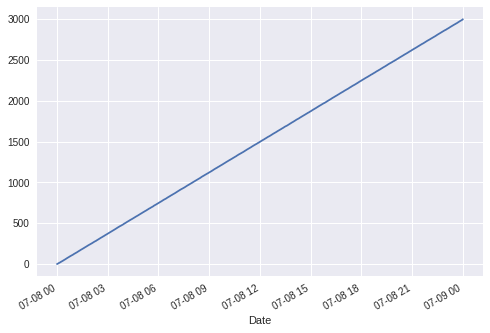

In [36]:
day_et.spent.plot()

In [25]:
day_et

,ts,TZ,imps,CPM,price,win,seconds_notif,buying,remaining,spent,engaged
Date,,,,,,,,,,,
2020-07-08 02:00:00.787000+02:00,1.594166e+09,Europe/Paris,1.0,6,0.006,True,36,True,3000.000,0.000,6.000000e-03
2020-07-08 02:00:02.796000+02:00,1.594166e+09,Europe/Paris,1.0,6,0.006,True,25,True,2999.994,0.000,1.200000e-02
2020-07-08 02:00:03.799000+02:00,1.594166e+09,Europe/Paris,1.0,6,0.006,True,49,True,2999.988,0.000,1.800000e-02
2020-07-08 02:00:06.808000+02:00,1.594166e+09,Europe/Paris,1.0,6,0.006,True,5,True,2999.982,0.000,2.400000e-02
2020-07-08 02:00:07.812000+02:00,1.594166e+09,Europe/Paris,1.0,6,0.006,True,49,True,2999.976,0.000,3.000000e-02
...,...,...,...,...,...,...,...,...,...,...,...
2020-07-08 23:59:51.295000+02:00,1.594246e+09,Europe/Paris,1.0,6,0.006,True,51,True,2700.612,299.142,2.520000e-01
2020-07-08 23:59:53.302000+02:00,1.594246e+09,Europe/Paris,1.0,6,0.006,True,29,True,2700.606,299.148,2.520000e-01
2020-07-08 23:59:54.306000+02:00,1.594246e+09,Europe/Paris,1.0,6,0.006,True,35,True,2700.600,299.148,2.580000e-01


### Intégration des timezones

On va tenter en premier lieu d'appliquer la méthode du budget par seconde par timezone.L'idée est tout d'abord d'étudier la proportion de chaque timezone sur un jour donné. Si cela semble être une bonne piste, on pourra ensuite intégrer l'estimation de cette proportion dans l'algorithme.

In [9]:
liste_tz = df.TZ.unique().tolist()

In [42]:
i = 0
for tz in liste_tz:
    i += 1
    if i == 1:
        temp = df[df.TZ == tz]
        temp.set_index('Date', inplace=True)
        data = temp['2020-07-08 00:00:00':'2020-07-08 23:59:59']
        data.index = data.index.tz_localize(None)
    else:
        temp = df[df.TZ == tz]
        temp.set_index('Date', inplace=True)
        day = temp['2020-07-08 00:00:00':'2020-07-08 23:59:59']
        day.index = day.index.tz_localize(None)
        data = pd.concat([data,day],axis=0)

In [48]:
data.sort_values(['ts'], inplace=True)

In [49]:
data

,ts,TZ,imps,CPM,price,win,seconds_notif
Date,,,,,,,
2020-07-08 02:00:00.787,1.594166e+09,Europe/Paris,1.000000,6,0.006000,True,25
2020-07-08 01:00:01.791,1.594166e+09,Europe/London,1.000000,6,0.006000,True,18
2020-07-08 02:00:02.796,1.594166e+09,Europe/Paris,1.000000,6,0.006000,True,26
2020-07-08 02:00:03.799,1.594166e+09,Europe/Paris,1.000000,6,0.006000,False,53
2020-07-08 01:00:04.801,1.594166e+09,Europe/London,1.000000,6,0.006000,True,12
...,...,...,...,...,...,...,...
2020-07-08 23:59:55.227,1.594278e+09,America/Los_Angeles,5.069074,9,0.045622,True,55
2020-07-08 23:59:55.358,1.594278e+09,America/Los_Angeles,40.330370,9,0.362973,True,372
2020-07-08 23:59:56.222,1.594278e+09,America/Los_Angeles,73.062963,9,0.657567,True,16


In [57]:
prop_tz = data.TZ.groupby(data['TZ']).count()/len(data)

In [58]:
prop_tz

TZ
America/Boise                   0.004617
America/Chicago                 0.381176
America/Denver                  0.011391
America/Detroit                 0.019781
America/Indiana/Indianapolis    0.003280
America/Kentucky/Louisville     0.001008
America/Los_Angeles             0.054929
America/New_York                0.414623
America/Phoenix                 0.012754
Europe/London                   0.032981
Europe/Paris                    0.063461
Name: TZ, dtype: float64

In [59]:
class Algo:
    def __init__(self, daily_budget, nb_hours_day, timezone):
        """Class constructor"""
        # Fixed attributes
        self.daily_budget = daily_budget
        self.building = list()
        # Impossible day and hour to initialize the setup
        self.day = 0
        self.engaged_budget = 0
        self.tz = pytz.timezone(timezone)
    
    def buying_decision(self, ts, price):
        """From a BR, decide whether to buy or not
        
        Arguments:
        :ts: timestamp of the BR
        :price: price of the BR
        """
        # TS de la BR
        weekday = ts.weekday()
        day = ts.day
        month = ts.month
        year = ts.year
        hour = ts.hour
        # If we begin a new day, we reset variables
        if self.day != day:
            if not self.building:
                self.building_data = pd.DataFrame.from_records(self.building)
            else:
                self.building_data = pd.DataFrame.from_records(self.building, index='Date')
            self.current_hour = -1
            self.remaining_budget_hour = 0
            self.remaining_budget = self.daily_budget
            self.spent_budget = 0
            self.surplus_hour = 0
            self.BT = [0]
            self.acceleration = [{'ts':self.tz.localize(datetime(year,month,day,0,0,0)),
                                  'A':0}]
            self.speed = [{'ts':self.tz.localize(datetime(year,month,day,0,0,0)),
                                  'S':0}]
            self.size_acceleration = 1
            self.sum_acceleration = 0
            self.size_speed = 1
            self.sum_speed = 0
            self.prop_table, self.unif, self.without_weekday = meta_prop(self.building_data)
        self.day = day
        # Changement of hour
        while hour != self.current_hour:
            self.current_hour += 1 
            self.remaining_hours = 24 - self.current_hour
            # Evolutive target
            self.surplus_hour += self.remaining_budget_hour / self.remaining_hours
            if self.unif:
                self.budget_hour = self.prop_table * self.daily_budget + self.surplus_hour
            elif self.without_weekday:
                self.budget_hour = (self.prop_table.iloc[self.current_hour, 0]/100)*self.daily_budget + self.surplus_hour
            else:
                self.budget_hour = (self.prop_table.iloc[self.current_hour, weekday]/100)*self.daily_budget + self.surplus_hour
            self.target = self.budget_hour/3600
            self.spent_hour = 0
            self.remaining_budget_hour = self.budget_hour - self.spent_hour
        # Remaining time before the end of the hour
        end_hour = self.tz.localize(datetime(year,month,day,hour,59,59,999999))
        remaining_time =  datetime.timestamp(end_hour) - datetime.timestamp(ts)
        # Average acceleration and speed
        created_time = self.acceleration[-1]['ts'] - timedelta(minutes=30)
        while self.acceleration[0]['ts'] < created_time:
            self.size_acceleration -= 1 
            self.sum_acceleration += self.acceleration[0]['A']
            del self.acceleration[0]
        try:
            average_acceleration = self.sum_acceleration / self.size_acceleration
        except ZeroDivisionError:
            average_acceleration = 0
        while self.speed[0]['ts'] < created_time:
            self.size_speed -= 1 
            self.sum_speed += self.speed[0]['S']
            del self.speed[0]
        try:
            average_speed = self.sum_speed / self.size_speed
        except ZeroDivisionError:
            average_speed = 0
        self.remaining_budget = self.daily_budget - (self.engaged_budget + self.spent_budget)
        alpha = average_acceleration
        # Calculation of bt
        try:
            bt = self.remaining_budget_hour * ((1 + alpha * average_speed) / remaining_time) 
        except ZeroDivisionError:
            bt = 1
        self.BT.append(bt)
        # Calculation of vt
        vt = self.BT[-1] - self.BT[-2] 
        self.speed.append({'ts':ts,
                          'S': vt})
        at = self.speed[-1]['S'] - self.speed[-2]['S']
        self.acceleration.append({'ts':ts,
                          'A': at})
        # Buying decision
        if (bt >= self.target) and (self.remaining_budget - price) >= 0:
            buying = True
            self.engaged_budget += price
            self.spent_hour += price
        else:
            buying = False
        self.remaining_budget_hour = self.budget_hour - self.spent_hour

        return buying     

    def send_pending_notifications(self,current_ts = None):
        """ Send notifications 
        
        :param current_ts: if None: will send all notifications, else send before current_ts
        :return:
        """
        while len(pending_notifications) > 0 and (pending_notifications[0]['timestamp'] <= current_ts if current_ts else True):
            ev = pending_notifications.pop(0)
            if ev['status'] == 'win':
                self.engaged_budget -= ev['br_price']
                self.spent_budget += ev['br_price']
            else:
                self.engaged_budget -= ev['br_price']
                self.spent_hour -= ev['br_price']

In [ ]:
pacing = Algo(daily_budget=3000, nb_hours_day=24, timezone='America/New_York')

In [ ]:
%%time
records = list()
pending_notifications = list()
day = 7
for current_ts, row in data.iterrows():
    # Send current notifications
    pacing.send_pending_notifications(current_ts)
    if current_ts.day != day:
        day = current_ts.day
        # Send remaining notifications
        pacing.send_pending_notifications()
        records[-1]['engaged'] = pacing.engaged_budget
        pacing.remaining_budget = pacing.daily_budget - (pacing.engaged_budget + pacing.spent_budget)
        records[-1]['remaining'] = pacing.remaining_budget
        records[-1]['spent'] = pacing.spent_budget
        
    # Receive BR
    buying = pacing.buying_decision(current_ts, row['price'])
    # Making a decision
    if buying:
        #Buying
        next_notif_ts = current_ts + timedelta(seconds=row['seconds_notif'])
        status = "win" if row['win'] else "lose"
        notif_id = uuid.uuid4()
        pending_notifications.append({"timestamp": next_notif_ts, "status": status, 'br_price': row['price'], 'id': notif_id})
        pending_notifications.sort(key=lambda x: x['timestamp'])
    record = {
        'buying':buying,
        'remaining':pacing.remaining_budget,
        'spent':pacing.spent_budget,
        'engaged':pacing.engaged_budget
    }
    records.append(record)
    pacing.building.append({'Date':current_ts,'imps':row['imps']})
# Send remaining notifications
pacing.send_pending_notifications()
# Update last row after sending last notifications
records[-1]['engaged'] = pacing.engaged_budget
pacing.remaining_budget = pacing.daily_budget - (pacing.engaged_budget + pacing.spent_budget)
records[-1]['remaining'] = pacing.remaining_budget
records[-1]['spent'] = pacing.spent_budget
pacing_df = pd.DataFrame.from_records(records)
new_df_et = pd.concat([data.reset_index(),pacing_df], axis=1, ignore_index=True)
new_df_et.columns = ['Date','ts','TZ','imps','CPM','price','win','seconds_notif',
                 'buying','remaining','spent','engaged']
new_df_et.set_index('Date', inplace=True)